# Deep Learning Project

The goal of this project is to compare the use of neural networks and SARIMA model to forecast seasonal time series.

In this notebook we will work with the Beer dataset used in the Time Series class and then we will replicate the same framework for other datasets.

In [6]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15,8

We will read the Beer dataset and plot the data:

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
beer = pd.read_csv('dt_datasets/australian_monthly_beer_production.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
beer['dpm'] = beer.index.daysinmonth
beer['daily'] = beer['Production'] / beer['dpm']

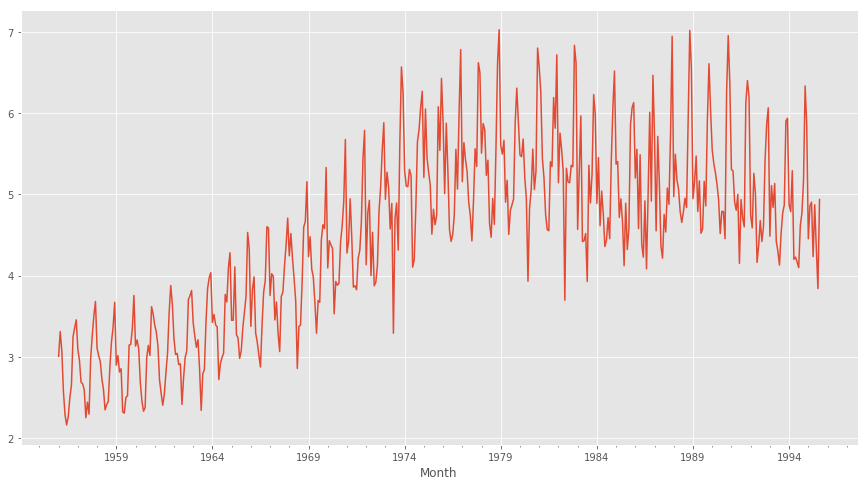

In [7]:
beer['daily'].plot()

# Function to create time steps

To feed the data to a NN, we need to prepare the data. We will create a series of time steps the will be the X variable and the next value in the series of time steps will be the target variable. We will create a function to create this data structure and feed our NNs:

In [8]:
def time_steps(series, window):
    
    steps = len(series)-window
    y = np.zeros(steps)
    X = np.zeros((steps, window))
    
    for i in range(steps):
        y[i] = series[i+window]
        X[i:] = np.array(series[i:i+window]).T
    
    return X, y, series.index[window:len(series)]

Checking the function:

In [81]:
time_steps(series=beer['daily'][0:12], window=4)

(array([[3.00645161, 3.31034483, 3.07096774, 2.57      ],
        [3.31034483, 3.07096774, 2.57      , 2.28709677],
        [3.07096774, 2.57      , 2.28709677, 2.16      ],
        [2.57      , 2.28709677, 2.16      , 2.26129032],
        [2.28709677, 2.16      , 2.26129032, 2.49354839],
        [2.16      , 2.26129032, 2.49354839, 2.65      ],
        [2.26129032, 2.49354839, 2.65      , 3.24516129],
        [2.49354839, 2.65      , 3.24516129, 3.35666667]]),
 array([2.28709677, 2.16      , 2.26129032, 2.49354839, 2.65      ,
        3.24516129, 3.35666667, 3.45483871]),
 DatetimeIndex(['1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
                '1956-09-01', '1956-10-01', '1956-11-01', '1956-12-01'],
               dtype='datetime64[ns]', name='Month', freq=None))

In [13]:
window_size=12
X, y, time = time_steps(series=beer['daily'], window=window_size)

In [14]:
len(y)
len(time)
time[0:10]

464

464

DatetimeIndex(['1957-01-01', '1957-02-01', '1957-03-01', '1957-04-01',
               '1957-05-01', '1957-06-01', '1957-07-01', '1957-08-01',
               '1957-09-01', '1957-10-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

# Creating the train, validation and test sets

Before starting exploring the different models, we will split our data:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train_v, X_test, y_train_v, y_test, time_train_v, time_test = train_test_split(X, y, time, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val, time_train, time_val = train_test_split(X_train_v, y_train_v, time_train_v, test_size=0.1, shuffle=False)

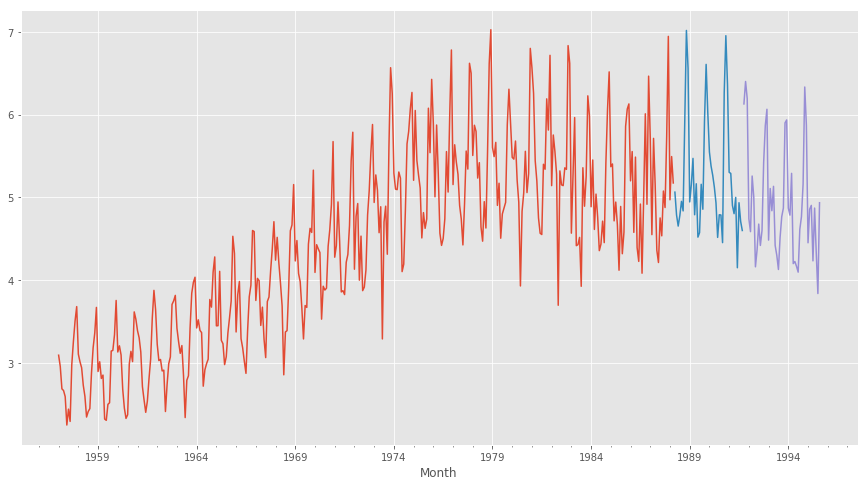

In [17]:
pd.Series(y_train.squeeze(), index=time_train).plot()
pd.Series(y_val, index=time_val).plot()
pd.Series(y_test, index=time_test).plot()

# Exploring models and transformations

This is an exploratory section, where we will explore different models and how transforming the data previously to feed it to NNs affect the results.

# Simple model

Here we will use a regular fully connected NN:

In [18]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.models import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [19]:
model = Sequential()
model.add(Dense(input_dim=window_size, output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 1, activation = None))

In [20]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

In [21]:
batch_size=32
epochs=50

In [22]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),shuffle=True)

Train on 375 samples, validate on 42 samples
Epoch 1/50
375/375 [==============================] - 1s 4ms/step - loss: 4.3638 - mean_absolute_error: 1.6730 - val_loss: 1.1058 - val_mean_absolute_error: 0.9618
Epoch 2/50
375/375 [==============================] - 0s 229us/step - loss: 0.6910 - mean_absolute_error: 0.6525 - val_loss: 0.5150 - val_mean_absolute_error: 0.6050
Epoch 3/50
375/375 [==============================] - 0s 149us/step - loss: 0.4127 - mean_absolute_error: 0.5184 - val_loss: 0.4486 - val_mean_absolute_error: 0.4756
Epoch 4/50
375/375 [==============================] - 0s 136us/step - loss: 0.3203 - mean_absolute_error: 0.4318 - val_loss: 0.4367 - val_mean_absolute_error: 0.5815
Epoch 5/50
375/375 [==============================] - 0s 146us/step - loss: 0.2447 - mean_absolute_error: 0.3854 - val_loss: 0.3357 - val_mean_absolute_error: 0.4299
Epoch 6/50
375/375 [==============================] - 0s 303us/step - loss: 0.2137 - mean_absolute_error: 0.3599 - val_loss: 0.

In [23]:
y_hat = model.predict(X_test)

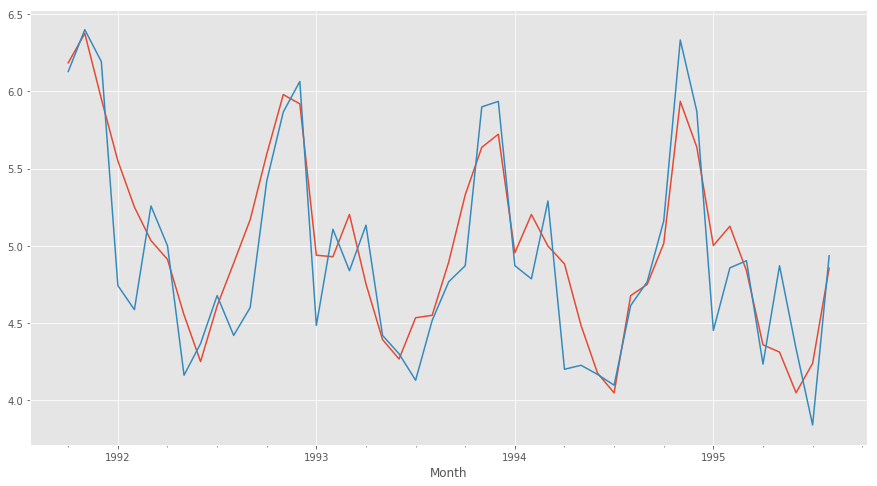

In [24]:
pd.Series(y_hat.squeeze(), index=time_test).plot()
pd.Series(y_test, index=time_test).plot()

In [25]:
# Evaluate the model
scores = model.evaluate(X_test, y_test)
print('Loss: %.3f' % scores[0])
print('MAE: %.3f' % scores[1])

47/47 [==============================] - 0s 106us/step
Loss: 0.107
MAE: 0.257


And we will measure the error on the test set:

In [29]:
from sklearn.metrics import mean_squared_error

def measure_error(actual, pred, label=None, show=True):
    sq_error = mean_squared_error(actual, pred)
    mse = np.mean(sq_error)**.5
    avg = np.mean(actual)
    errors = {'RMSE': mse, 'RMSE_pcent': mse / avg, 'label':label}
    if show:
        for (k,v) in errors.items():
            print('%s = %s' % (k,v))
    return errors

measure_error(actual=y_hat, pred=y_test, label=None, show=True)

RMSE = 0.32658251150205436
label = None
RMSE_pcent = 0.0653413782065732


{'RMSE': 0.32658251150205436, 'RMSE_pcent': 0.0653413782065732, 'label': None}

# Simple model with log transform

We will check if the model perfoms better with a log transform. We can see that it is not the case.

In [30]:
window_size=12
X_l, y_l, time_l = time_steps(series=np.log(beer['daily']), window=window_size)

In [31]:
X_train_v_l, X_test_l, y_train_v_l, y_test_l, time_train_v_l, time_test_l = train_test_split(X_l, y_l, time_l, test_size=0.1, shuffle=False)
X_train_l, X_val_l, y_train_l, y_val_l, time_train_l, time_val_l = train_test_split(X_train_v_l, y_train_v_l, time_train_v_l, test_size=0.1, shuffle=False)

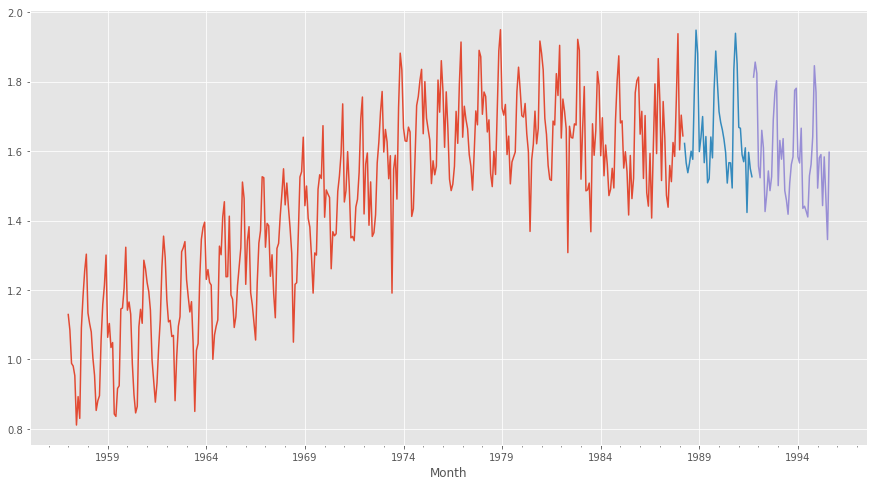

In [32]:
pd.Series(y_train_l.squeeze(), index=time_train_l).plot()
pd.Series(y_val_l, index=time_val_l).plot()
pd.Series(y_test_l, index=time_test_l).plot()

In [33]:
model2 = Sequential()
model2.add(Dense(input_dim=window_size, output_dim = 128, activation = 'relu'))
model2.add(Dense(output_dim = 128, activation = 'relu'))
model2.add(Dense(output_dim = 1, activation = None))

# Compiling the CNN
model2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

In [34]:
batch_size=32
epochs=20
model2.fit(X_train_l, y_train_l, batch_size=batch_size, epochs=epochs, validation_data=(X_val_l, y_val_l),shuffle=True)

Train on 375 samples, validate on 42 samples
Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.5341 - mean_absolute_error: 0.6000 - val_loss: 0.2479 - val_mean_absolute_error: 0.4832
Epoch 2/20
375/375 [==============================] - 0s 327us/step - loss: 0.0702 - mean_absolute_error: 0.2223 - val_loss: 0.0754 - val_mean_absolute_error: 0.2460
Epoch 3/20
375/375 [==============================] - 0s 221us/step - loss: 0.0345 - mean_absolute_error: 0.1531 - val_loss: 0.0400 - val_mean_absolute_error: 0.1775
Epoch 4/20
375/375 [==============================] - 0s 223us/step - loss: 0.0214 - mean_absolute_error: 0.1185 - val_loss: 0.0176 - val_mean_absolute_error: 0.0968
Epoch 5/20
375/375 [==============================] - 0s 269us/step - loss: 0.0180 - mean_absolute_error: 0.1098 - val_loss: 0.0160 - val_mean_absolute_error: 0.1103
Epoch 6/20
375/375 [==============================] - 0s 101us/step - loss: 0.0153 - mean_absolute_error: 0.0989 - val_loss: 0.

In [35]:
y_hat_l = model2.predict(X_test_l)

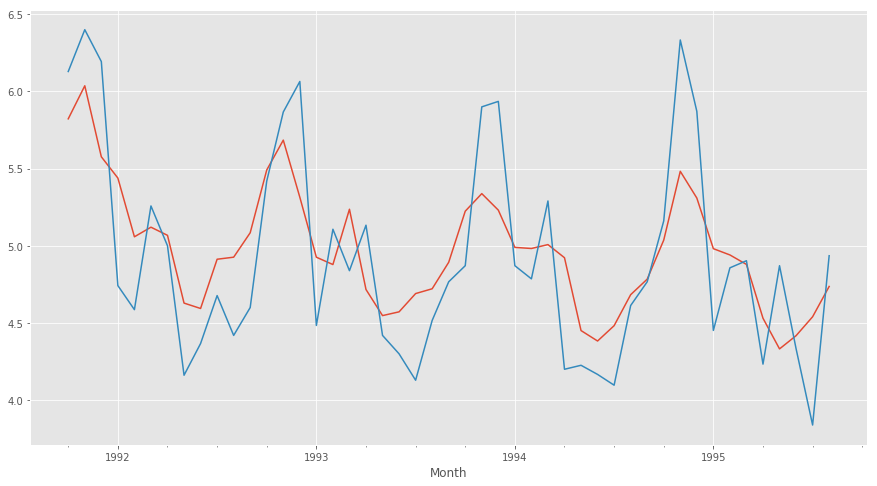

In [36]:
pd.Series(np.exp(y_hat_l).squeeze(), index=time_test_l).plot()
pd.Series(np.exp(y_test_l), index=time_test_l).plot()

In [37]:
# Evaluate the model
scores = model2.evaluate(X_test, y_test)
print('Loss: %.3f' % scores[0])
print('MAE: %.3f' % scores[1])

47/47 [==============================] - 0s 85us/step
Loss: 0.164
MAE: 0.331


# Simple model with differencing

Now we will see if fitting the model to the differenced series helps. We can see that it does not help.

In [38]:
beer['daily'].diff(periods=1).dropna().head()

Month
1956-02-01    0.303893
1956-03-01   -0.239377
1956-04-01   -0.500968
1956-05-01   -0.282903
1956-06-01   -0.127097
Name: daily, dtype: float64

In [39]:
window_size=12
X_d, y_d, time_d = time_steps(series=beer['daily'].diff(periods=1).dropna(), window=window_size)

In [40]:
X_train_v_d, X_test_d, y_train_v_d, y_test_d, time_train_v_d, time_test_d = train_test_split(X_d, y_d, time_d, test_size=0.1, shuffle=False)
X_train_d, X_val_d, y_train_d, y_val_d, time_train_d, time_val_d = train_test_split(X_train_v_d, y_train_v_d, time_train_v_d, test_size=0.1, shuffle=False)

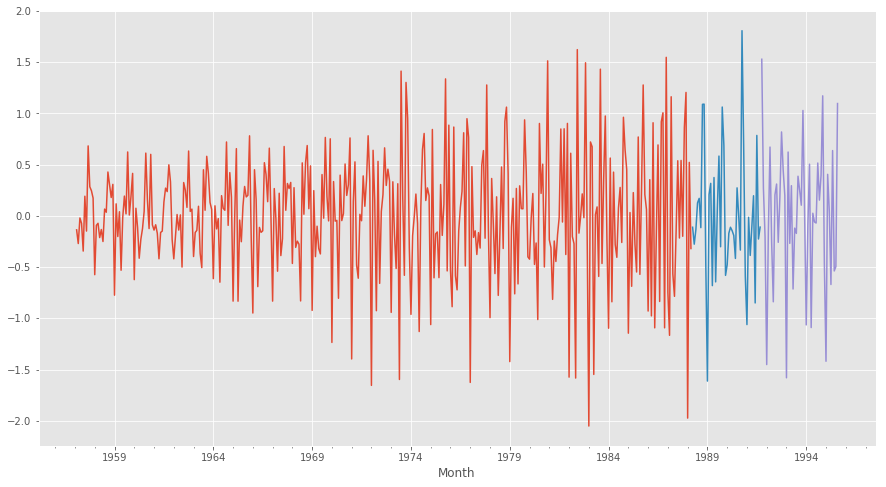

In [41]:
pd.Series(y_train_d.squeeze(), index=time_train_d).plot()
pd.Series(y_val_d, index=time_val_d).plot()
pd.Series(y_test_d, index=time_test_d).plot()

In [42]:
model3 = Sequential()
model3.add(Dense(input_dim=window_size, output_dim = 128, activation = 'relu'))
model3.add(Dense(output_dim = 128, activation = 'relu'))
model3.add(Dense(output_dim = 50, activation = 'relu'))
model3.add(Dense(output_dim = 20, activation = 'relu'))
model3.add(Dense(output_dim = 1, activation = None))

# Compiling the CNN
model3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

In [43]:
batch_size=32
epochs=50
model3.fit(X_train_d, y_train_d, batch_size=batch_size, epochs=epochs, validation_data=(X_val_d, y_val_d),shuffle=True)

Train on 374 samples, validate on 42 samples
Epoch 1/50
374/374 [==============================] - 1s 3ms/step - loss: 0.3323 - mean_absolute_error: 0.4326 - val_loss: 0.3139 - val_mean_absolute_error: 0.4244
Epoch 2/50
374/374 [==============================] - 0s 117us/step - loss: 0.2486 - mean_absolute_error: 0.3651 - val_loss: 0.2345 - val_mean_absolute_error: 0.3719
Epoch 3/50
374/374 [==============================] - 0s 117us/step - loss: 0.1850 - mean_absolute_error: 0.3208 - val_loss: 0.2105 - val_mean_absolute_error: 0.3589
Epoch 4/50
374/374 [==============================] - 0s 149us/step - loss: 0.1448 - mean_absolute_error: 0.2852 - val_loss: 0.1814 - val_mean_absolute_error: 0.3320
Epoch 5/50
374/374 [==============================] - 0s 147us/step - loss: 0.1138 - mean_absolute_error: 0.2601 - val_loss: 0.1912 - val_mean_absolute_error: 0.3474
Epoch 6/50
374/374 [==============================] - 0s 187us/step - loss: 0.0952 - mean_absolute_error: 0.2381 - val_loss: 0.

Epoch 50/50
374/374 [==============================] - 0s 157us/step - loss: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.2097 - val_mean_absolute_error: 0.3605


In [44]:
y_hat_d = model3.predict(X_test_d)

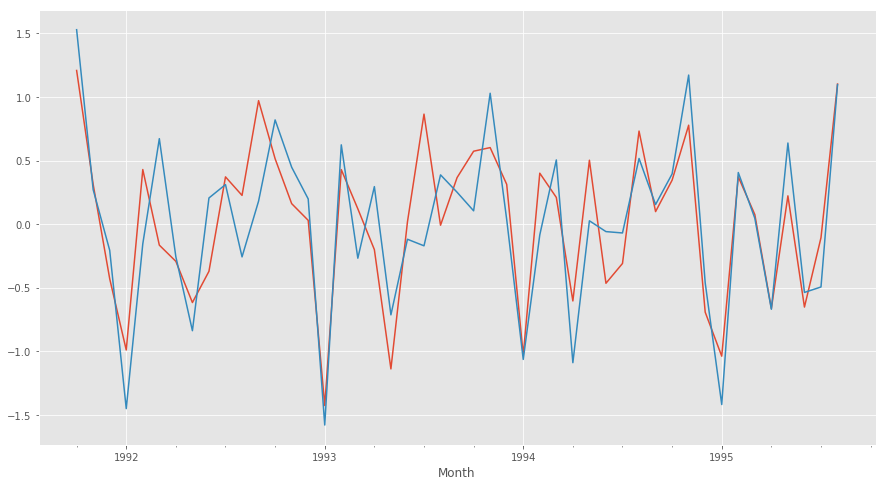

In [45]:
pd.Series(y_hat_d.squeeze(), index=time_test_d).plot()
pd.Series(y_test_d, index=time_test_d).plot()

In [46]:
pd.Series(y_test_d, index=time_test_d).head()

Month
1991-10-01    1.529032
1991-11-01    0.270968
1991-12-01   -0.206452
1992-01-01   -1.451613
1992-02-01   -0.155729
dtype: float64

In [47]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval] 
    
history=[beer['daily']['1991-09-01']] #first value
y_hat_d_undiff=[]

for pred in y_hat_d:
    pred_new = inverse_difference(history, pred, interval=1)
    y_hat_d_undiff.append(pred_new)
    history.append(pred_new)

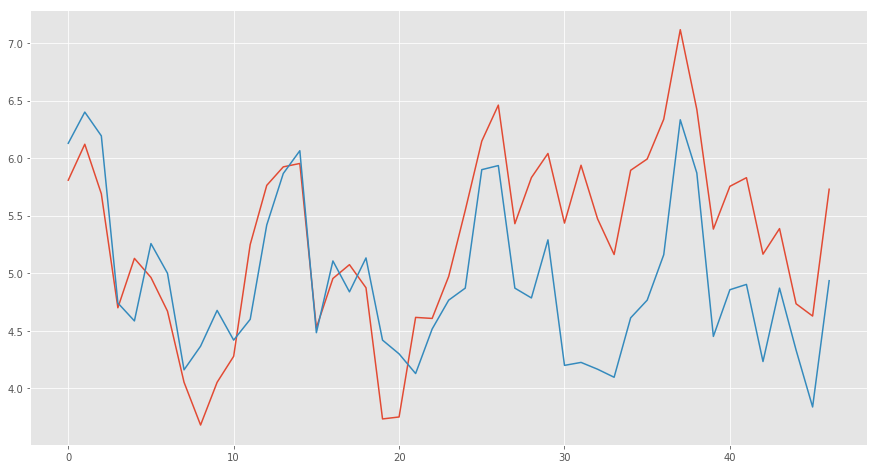

In [48]:
plt.plot(y_hat_d_undiff)
plt.plot(y_test)

# RNN

Now we will try an RNN architecture.

In [49]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_val.shape

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(375, 12, 1)

(42, 12, 1)

(47, 12, 1)

In [50]:
model4 = Sequential()
model4.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu', return_sequences=True))
model4.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu'))
model4.add(Dense(1, activation=None))

# Compiling the CNN
model4.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

In [51]:
batch_size=32
epochs=50
model4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),shuffle=True)

Train on 375 samples, validate on 42 samples
Epoch 1/50
375/375 [==============================] - 3s 9ms/step - loss: 9.2380 - mean_absolute_error: 2.6195 - val_loss: 0.6402 - val_mean_absolute_error: 0.6385
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 1.0596 - mean_absolute_error: 0.8618 - val_loss: 0.7605 - val_mean_absolute_error: 0.7652
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 0.6727 - mean_absolute_error: 0.6776 - val_loss: 0.6820 - val_mean_absolute_error: 0.7285
Epoch 4/50
375/375 [==============================] - 1s 3ms/step - loss: 0.5281 - mean_absolute_error: 0.5837 - val_loss: 0.5600 - val_mean_absolute_error: 0.6296
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4288 - mean_absolute_error: 0.5258 - val_loss: 0.7239 - val_mean_absolute_error: 0.7730
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4502 - mean_absolute_error: 0.5342 - val_loss: 0.6263 - val

In [52]:
y_hat_rnn = model4.predict(X_test)

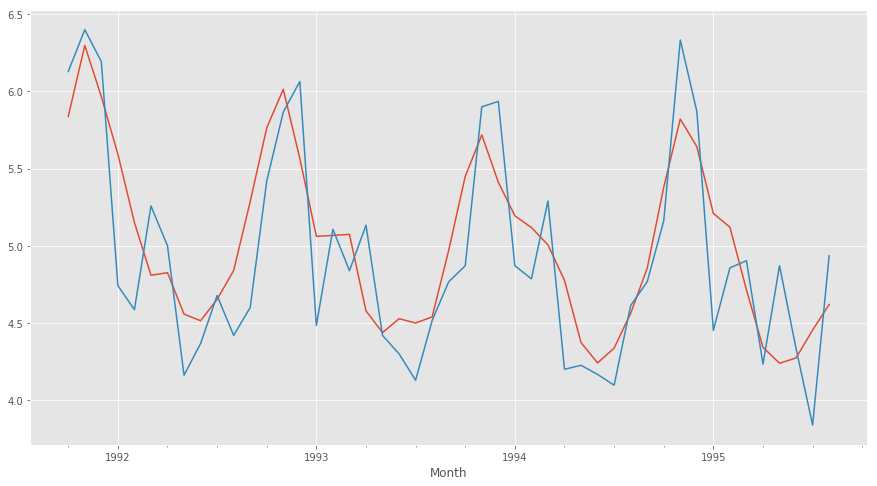

In [53]:
pd.Series(y_hat_rnn.squeeze(), index=time_test).plot()
pd.Series(y_test, index=time_test).plot()

In [54]:
from sklearn.metrics import mean_squared_error

def measure_error(actual, pred, label=None, show=True):
    sq_error = mean_squared_error(actual, pred)
    mse = np.mean(sq_error)**.5
    avg = np.mean(actual)
    errors = {'RMSE': mse, 'RMSE_pcent': mse / avg, 'label':label}
    if show:
        for (k,v) in errors.items():
            print('%s = %s' % (k,v))
    return errors

measure_error(actual=y_hat_rnn, pred=y_test, label=None, show=True)

RMSE = 0.38235266741836155
label = None
RMSE_pcent = 0.07637636828351807


{'RMSE': 0.38235266741836155, 'RMSE_pcent': 0.07637636828351807, 'label': None}

# Function to run a model

Now that we have an idea of how different models can be used and that no transformation of the data is required, we will create a function to run different NN models and test different architectures:

In [55]:
def run_time_series_model(series, window_size, batch_size, keras_model, epochs, is_rnn=False):
    
    X, y, time = time_steps(series=series, window=window_size)
    X_train_v, X_test, y_train_v, y_test, time_train_v, time_test = train_test_split(X, y, time, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val, time_train, time_val = train_test_split(X_train_v, y_train_v, time_train_v, test_size=0.1, shuffle=False)
    
    pd.Series(y_train.squeeze(), index=time_train).plot()
    pd.Series(y_val, index=time_val).plot()
    pd.Series(y_test, index=time_test).plot()
    plt.title('Train, Validation and Test sets')
    plt.show();
    
    if is_rnn==True:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    keras_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),shuffle=True)
    y_hat = keras_model.predict(X_test)
    
    # Evaluate the model
    scores = keras_model.evaluate(X_test, y_test)
    print('Mean Absolute Error on Test set')
    print('Loss: %.3f' % scores[0])
    print('MSE: %.3f' % scores[1])
    
    
    pd.Series(y_hat.squeeze(), index=time_test).plot()
    pd.Series(y_test, index=time_test).plot()
    plt.title('Predictions vs Test')
    plt.show();
    
    return y_hat, y_test, scores[1]
    

And now we will test the different models:

In [56]:
series=beer['daily']
window_size=12
batch_size=32
epochs=20

model = Sequential()
model.add(Dense(input_dim=window_size, output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 1, activation = None))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
keras_model = model

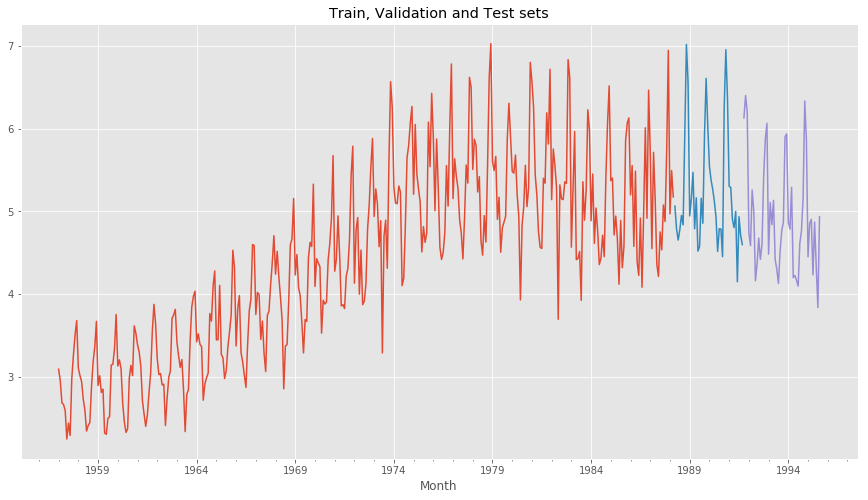

Train on 375 samples, validate on 42 samples
Epoch 1/20
375/375 [==============================] - 1s 4ms/step - loss: 7.6556 - mean_squared_error: 7.6556 - val_loss: 1.8228 - val_mean_squared_error: 1.8228
Epoch 2/20
375/375 [==============================] - 0s 136us/step - loss: 0.8367 - mean_squared_error: 0.8367 - val_loss: 0.7806 - val_mean_squared_error: 0.7806
Epoch 3/20
375/375 [==============================] - 0s 191us/step - loss: 0.4159 - mean_squared_error: 0.4159 - val_loss: 0.5957 - val_mean_squared_error: 0.5957
Epoch 4/20
375/375 [==============================] - 0s 125us/step - loss: 0.3422 - mean_squared_error: 0.3422 - val_loss: 0.3664 - val_mean_squared_error: 0.3664
Epoch 5/20
375/375 [==============================] - 0s 144us/step - loss: 0.2639 - mean_squared_error: 0.2639 - val_loss: 0.3084 - val_mean_squared_error: 0.3084
Epoch 6/20
375/375 [==============================] - 0s 112us/step - loss: 0.2122 - mean_squared_error: 0.2122 - val_loss: 0.2650 - val_

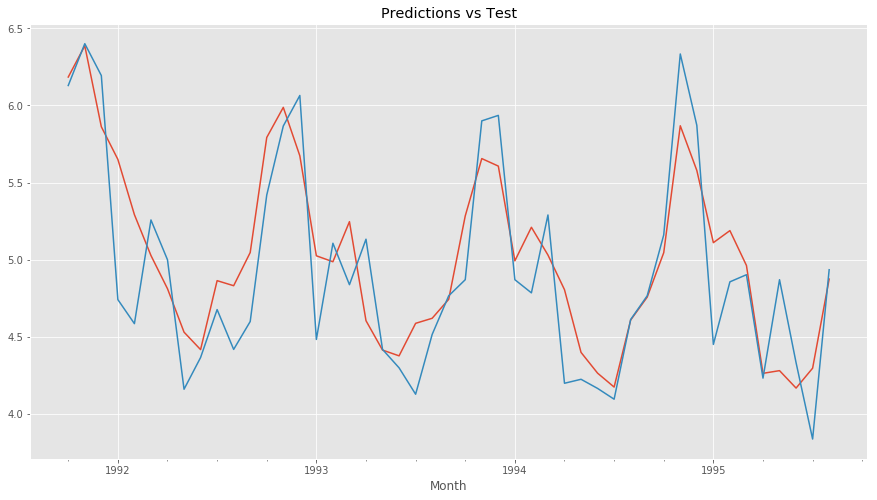

In [57]:
y_hat, y_test, mae = run_time_series_model(series, window_size, batch_size, keras_model, epochs, is_rnn=False)

In [58]:
epochs=50
window_size=12

model4 = Sequential()
model4.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu', return_sequences=True))
model4.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu'))
model4.add(Dense(1, activation=None))

# Compiling the CNN
model4.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])

keras_model = model4

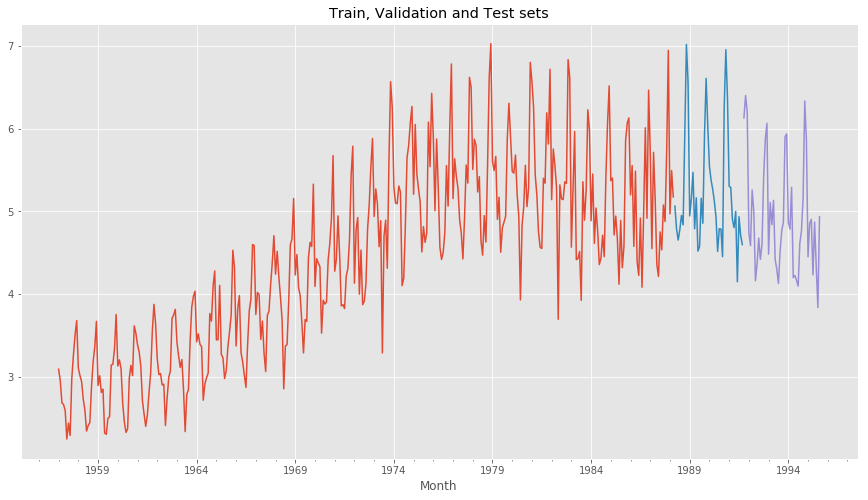

Train on 375 samples, validate on 42 samples
Epoch 1/50
375/375 [==============================] - 5s 13ms/step - loss: 10.8316 - mean_squared_error: 10.8316 - val_loss: 1.4176 - val_mean_squared_error: 1.4176
Epoch 2/50
375/375 [==============================] - 1s 3ms/step - loss: 1.5358 - mean_squared_error: 1.5358 - val_loss: 3.2267 - val_mean_squared_error: 3.2267
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 1.0714 - mean_squared_error: 1.0714 - val_loss: 0.6273 - val_mean_squared_error: 0.6273
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.6454 - mean_squared_error: 0.6454 - val_loss: 0.6209 - val_mean_squared_error: 0.6209
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.5776 - mean_squared_error: 0.5776 - val_loss: 0.5968 - val_mean_squared_error: 0.5968
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4592 - mean_squared_error: 0.4592 - val_loss: 0.6298 - val_mean_sq

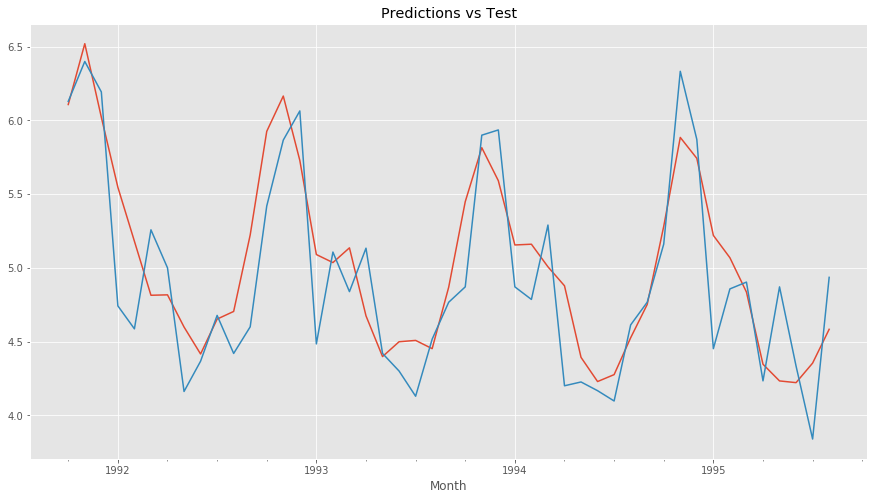

In [59]:
y_hat4, y_test4, mae4 = run_time_series_model(series, window_size, batch_size, keras_model, epochs, is_rnn=True)

In [60]:
epochs=50
window_size=12

model5 = Sequential()
model5.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu', return_sequences=True))
model5.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu', return_sequences=True))
model5.add(LSTM(128, batch_input_shape=(None,window_size,1), activation='relu'))
model5.add(Dense(1, activation=None))

# Compiling the CNN
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)
model5.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

keras_model = model5

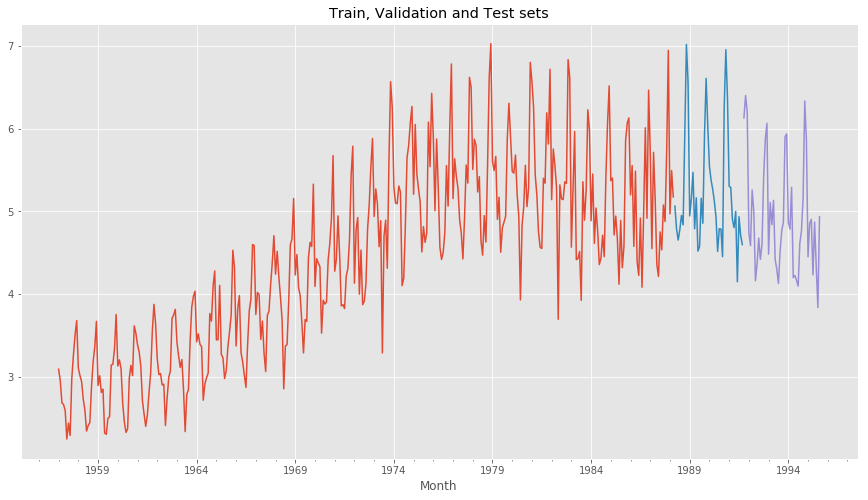

Train on 375 samples, validate on 42 samples
Epoch 1/50
375/375 [==============================] - 11s 28ms/step - loss: 13.7503 - mean_squared_error: 13.7503 - val_loss: 0.8661 - val_mean_squared_error: 0.8661
Epoch 2/50
375/375 [==============================] - 2s 4ms/step - loss: 2.8281 - mean_squared_error: 2.8281 - val_loss: 1.7045 - val_mean_squared_error: 1.7045
Epoch 3/50
375/375 [==============================] - 1s 3ms/step - loss: 1.3500 - mean_squared_error: 1.3500 - val_loss: 2.2529 - val_mean_squared_error: 2.2529
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.8539 - mean_squared_error: 0.8539 - val_loss: 1.0716 - val_mean_squared_error: 1.0716
Epoch 5/50
375/375 [==============================] - 2s 6ms/step - loss: 0.5572 - mean_squared_error: 0.5572 - val_loss: 0.9867 - val_mean_squared_error: 0.9867
Epoch 6/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4796 - mean_squared_error: 0.4796 - val_loss: 0.9360 - val_mean_s

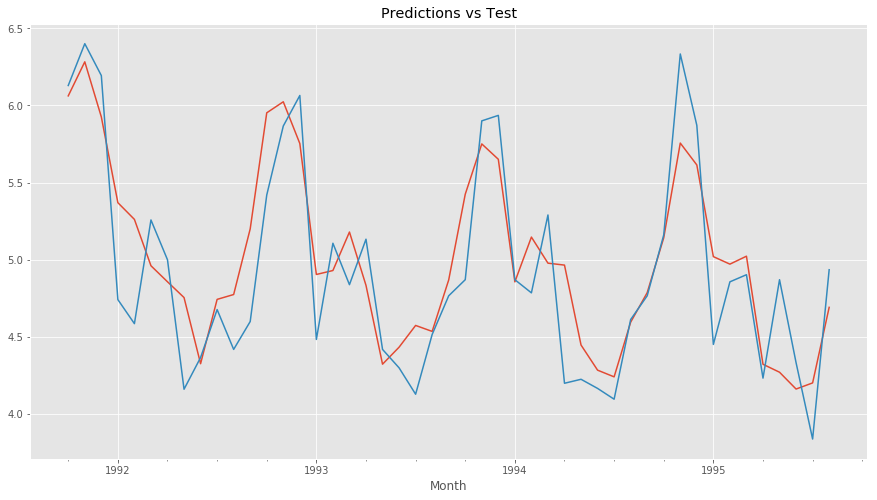

In [61]:
y_hat5, y_test5, mse5 = run_time_series_model(series, window_size, batch_size, keras_model, epochs, is_rnn=True)

In [65]:
measure_error(actual=y_test5, pred=y_hat5, label=None, show=True)

RMSE = 0.3451372907096409
label = None
RMSE_pcent = 0.07019539895941117


{'RMSE': 0.3451372907096409, 'RMSE_pcent': 0.07019539895941117, 'label': None}

In [66]:
epochs=50
window_size=12

model6 = Sequential()
model6.add(LSTM(128*2, recurrent_dropout=0.1, batch_input_shape=(None,window_size,1), activation='relu', return_sequences=True))
model6.add(LSTM(128*2, recurrent_dropout=0.1, activation='relu', return_sequences=True))
model6.add(LSTM(128, recurrent_dropout=0.1, activation='relu'))
model6.add(Dense(1, activation=None))

# Compiling the CNN
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)
model6.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

keras_model = model6

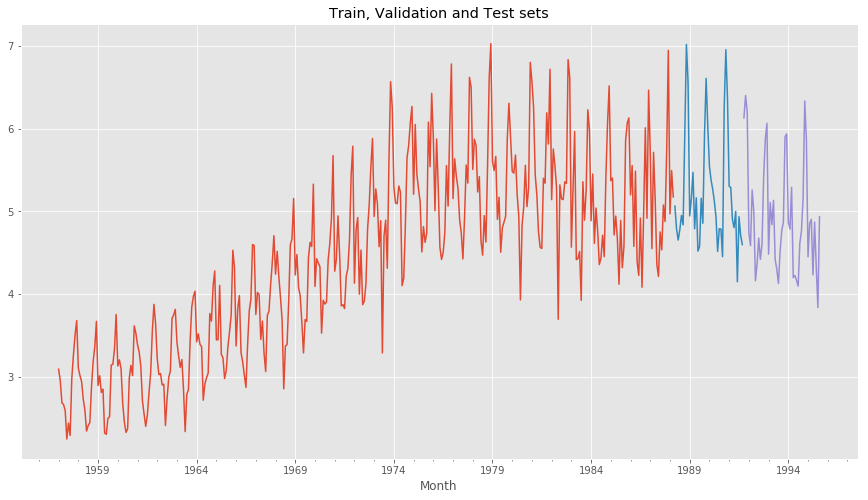

Train on 375 samples, validate on 42 samples
Epoch 1/10
375/375 [==============================] - 4s 11ms/step - loss: 0.1615 - mean_squared_error: 0.1615 - val_loss: 0.2135 - val_mean_squared_error: 0.2135
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.1343 - val_mean_squared_error: 0.1343
Epoch 3/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1488 - mean_squared_error: 0.1488 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 4/10
375/375 [==============================] - 2s 7ms/step - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1899 - val_mean_squared_error: 0.1899
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1791 - mean_squared_error: 0.1791 - val_loss: 0.2350 - val_mean_squared_error: 0.2350
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.2111 - mean_squared_error: 0.2111 - val_loss: 0.1590 - val_mean_squa

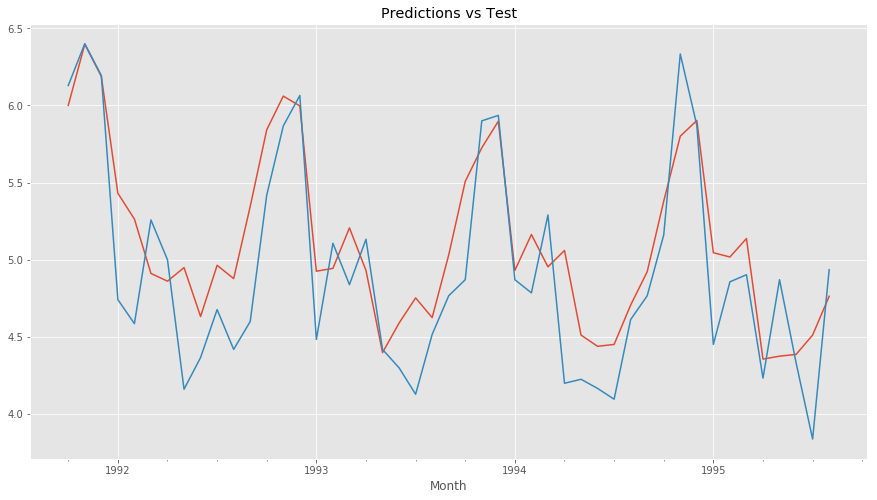

In [71]:
epochs=10
y_hat6, y_test6, mse6 = run_time_series_model(series, window_size, batch_size, keras_model, epochs, is_rnn=True)

In [72]:
def measure_error(actual, pred, label=None, show=True):
    sq_error = mean_squared_error(actual, pred)
    mse = np.mean(sq_error)**.5
    avg = np.mean(actual)
    errors = {'RMSE': mse, 'RMSE_pcent': mse / avg, 'label':label}
    if show:
        for (k,v) in errors.items():
            print('%s = %s' % (k,v))
    return errors

measure_error(actual=y_test6, pred=y_hat6, label=None, show=True)

RMSE = 0.38786228947843215
label = None
RMSE_pcent = 0.07888497964178012


{'RMSE': 0.38786228947843215, 'RMSE_pcent': 0.07888497964178012, 'label': None}

In [191]:
epochs=50
window_size=12

model7 = Sequential()
model7.add(LSTM(24, recurrent_dropout=0.1, batch_input_shape=(None,window_size,1), activation='relu'))#, return_sequences=True))
#model7.add(LSTM(128*2, recurrent_dropout=0.1, activation='relu', return_sequences=True))
#model7.add(LSTM(128, recurrent_dropout=0.1, activation='relu'))
model7.add(Dense(1, activation=None))

# Compiling the CNN
opt = keras.optimizers.adam(lr=0.003, decay=1e-6)
model7.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

keras_model = model7

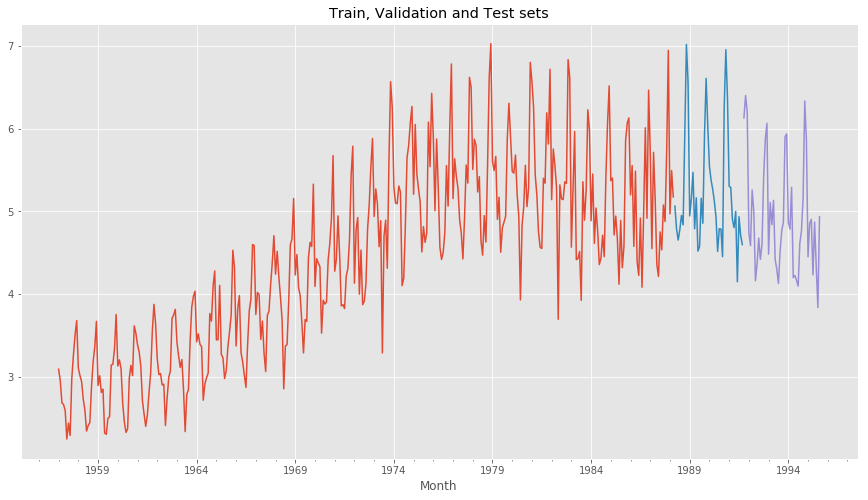

Train on 375 samples, validate on 42 samples
Epoch 1/10
375/375 [==============================] - 0s 577us/step - loss: 0.1454 - mean_squared_error: 0.1454 - val_loss: 0.1674 - val_mean_squared_error: 0.1674
Epoch 2/10
375/375 [==============================] - 0s 758us/step - loss: 0.1408 - mean_squared_error: 0.1408 - val_loss: 0.1689 - val_mean_squared_error: 0.1689
Epoch 3/10
375/375 [==============================] - 0s 848us/step - loss: 0.1487 - mean_squared_error: 0.1487 - val_loss: 0.1715 - val_mean_squared_error: 0.1715
Epoch 4/10
375/375 [==============================] - 0s 593us/step - loss: 0.1340 - mean_squared_error: 0.1340 - val_loss: 0.1542 - val_mean_squared_error: 0.1542
Epoch 5/10
375/375 [==============================] - 1s 2ms/step - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.1600 - val_mean_squared_error: 0.1600
Epoch 6/10
375/375 [==============================] - 0s 787us/step - loss: 0.1292 - mean_squared_error: 0.1292 - val_loss: 0.1485 - val_

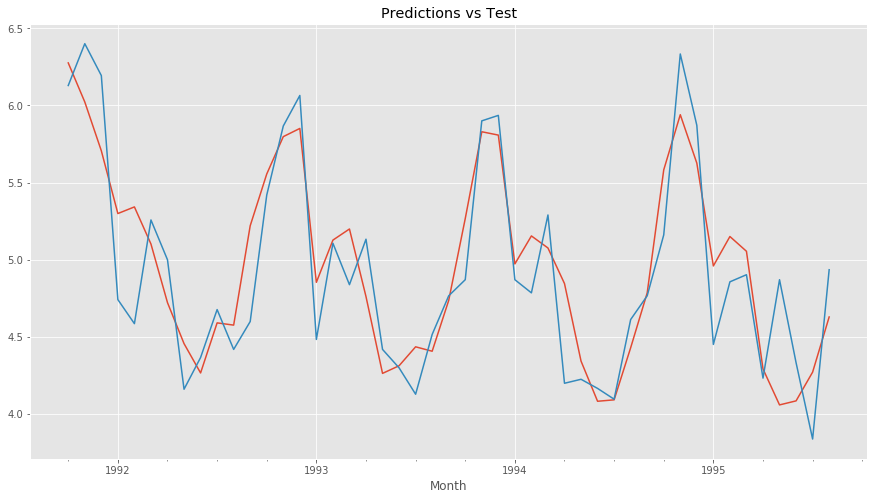

In [198]:
epochs=10
y_hat7, y_test7, mse7 = run_time_series_model(series, window_size, batch_size, keras_model, epochs, is_rnn=True)

In [199]:
measure_error(actual=y_test7, pred=y_hat7, label=None, show=True)

RMSE = 0.32983112532928904
label = None
RMSE_pcent = 0.06708236998707556


{'RMSE': 0.32983112532928904, 'RMSE_pcent': 0.06708236998707556, 'label': None}

# Best Models

After trying different models, we picked the best RNN and Regular fully connected NN. 

Best RNN:

In [200]:
epochs=50
window_size=12

model8 = Sequential()
model8.add(LSTM(24, recurrent_dropout=0.1, batch_input_shape=(None,window_size,1), activation='relu'))      #, return_sequences=True))
model8.add(Dense(1, activation=None))

# Compiling the CNN
opt = keras.optimizers.adam(lr=0.003, decay=1e-6)
model8.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

keras_model_7_2 = model8

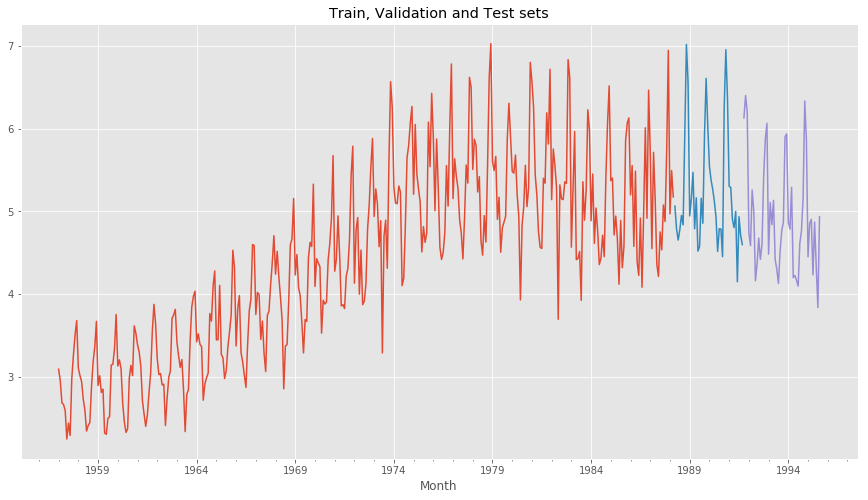

Train on 375 samples, validate on 42 samples
Epoch 1/30
375/375 [==============================] - 0s 630us/step - loss: 0.1151 - mean_squared_error: 0.1151 - val_loss: 0.1270 - val_mean_squared_error: 0.1270
Epoch 2/30
375/375 [==============================] - 0s 947us/step - loss: 0.1217 - mean_squared_error: 0.1217 - val_loss: 0.1439 - val_mean_squared_error: 0.1439
Epoch 3/30
375/375 [==============================] - 0s 870us/step - loss: 0.1179 - mean_squared_error: 0.1179 - val_loss: 0.1461 - val_mean_squared_error: 0.1461
Epoch 4/30
375/375 [==============================] - 1s 1ms/step - loss: 0.1098 - mean_squared_error: 0.1098 - val_loss: 0.1239 - val_mean_squared_error: 0.1239
Epoch 5/30
375/375 [==============================] - 1s 2ms/step - loss: 0.1196 - mean_squared_error: 0.1196 - val_loss: 0.1300 - val_mean_squared_error: 0.1300
Epoch 6/30
375/375 [==============================] - 1s 1ms/step - loss: 0.1206 - mean_squared_error: 0.1206 - val_loss: 0.1282 - val_mean

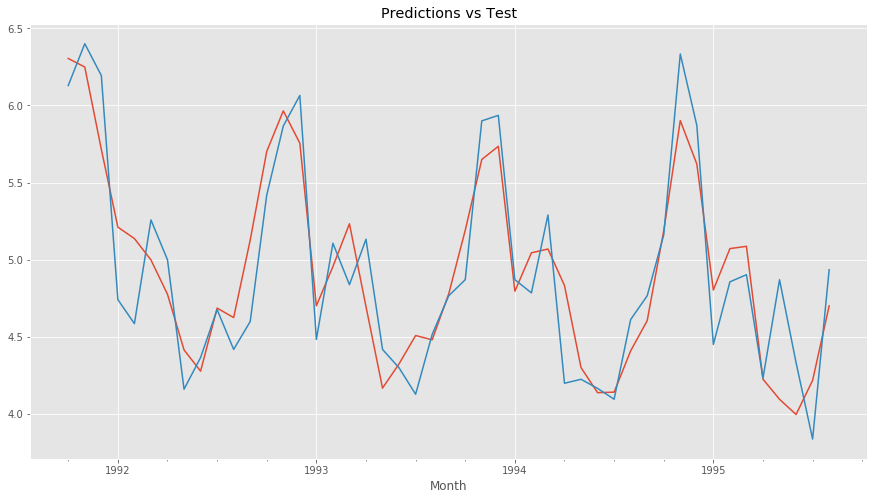

In [237]:
epochs=30
y_hat8, y_test8, mse8 = run_time_series_model(series, window_size, batch_size, keras_model_7_2, epochs, is_rnn=True)

In [239]:
model8.save_weights("best_rnn_model.h5")

In [244]:
measure_error(actual=y_test8, pred=y_hat8, label=None, show=True)

RMSE = 0.30242346249845
label = None
RMSE_pcent = 0.06150809018960705


{'RMSE': 0.30242346249845, 'RMSE_pcent': 0.06150809018960705, 'label': None}

Best simple NN:

In [240]:
epochs=50
window_size=12

smodel2 = Sequential()
smodel2.add(Dense(input_dim=window_size, output_dim = 128, activation = 'relu'))
smodel2.add(Dense(output_dim = 128, activation = 'relu'))
smodel2.add(Dense(output_dim = 128, activation = 'relu'))
smodel2.add(Dense(output_dim = 1, activation = None))

# Compiling the CNN
opt = keras.optimizers.adam(lr=0.003, decay=1e-6)
smodel2.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

keras_model_s = smodel2

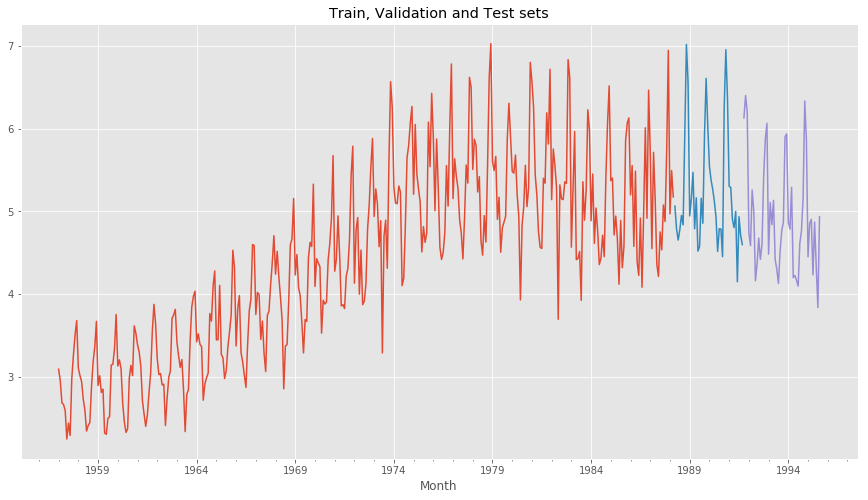

Train on 375 samples, validate on 42 samples
Epoch 1/30
375/375 [==============================] - 0s 170us/step - loss: 0.1223 - mean_squared_error: 0.1223 - val_loss: 0.4279 - val_mean_squared_error: 0.4279
Epoch 2/30
375/375 [==============================] - 0s 170us/step - loss: 0.1728 - mean_squared_error: 0.1728 - val_loss: 0.1636 - val_mean_squared_error: 0.1636
Epoch 3/30
375/375 [==============================] - 0s 285us/step - loss: 0.1137 - mean_squared_error: 0.1137 - val_loss: 0.1495 - val_mean_squared_error: 0.1495
Epoch 4/30
375/375 [==============================] - 0s 218us/step - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.1445 - val_mean_squared_error: 0.1445
Epoch 5/30
375/375 [==============================] - 0s 298us/step - loss: 0.1019 - mean_squared_error: 0.1019 - val_loss: 0.2024 - val_mean_squared_error: 0.2024
Epoch 6/30
375/375 [==============================] - 0s 181us/step - loss: 0.1063 - mean_squared_error: 0.1063 - val_loss: 0.1393 - va

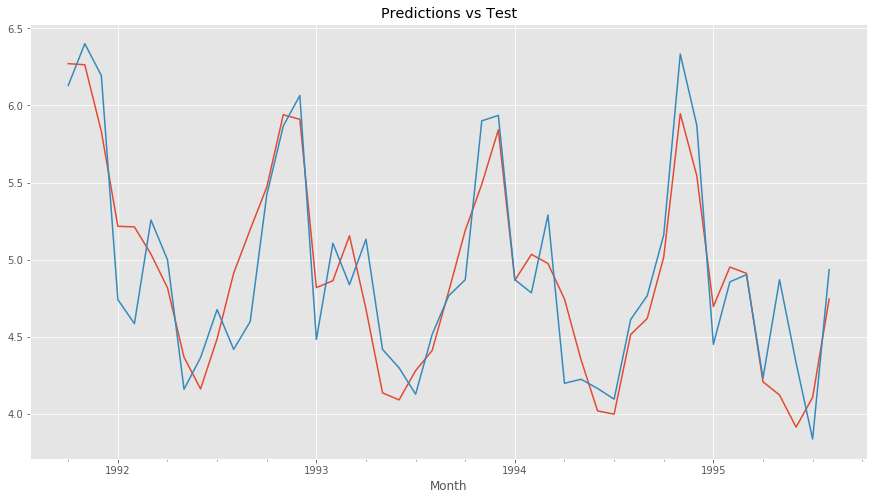

In [251]:
epochs=30
y_hat9, y_test9, mse9 = run_time_series_model(series, window_size, batch_size, keras_model_s, epochs, is_rnn=False)

In [253]:
smodel2.save_weights("best_simple_model.h5")

In [252]:
measure_error(actual=y_test9, pred=y_hat9, label=None, show=True)

RMSE = 0.3010419957332354
label = None
RMSE_pcent = 0.061227121968137795


{'RMSE': 0.3010419957332354, 'RMSE_pcent': 0.061227121968137795, 'label': None}

# Making out-of-sample Forecasts

We are assuming a real life scenario, where the test set data to create the time steps is not available, and we will make the next prediction based on the last predictions. To buid this forecasts we will create the function forecast_lstm and forecast_nn to make this kind of prediction:

In [334]:
def forecast_lstm(model, X_test, horizon):
    
    forecast=[]
    test = X_test[0]
    for i in range(horizon):
        pred = model.predict(test.reshape(1,window_size,-1))[0][0]
        forecast.append(pred)
        test = np.append(test[1:],pred)
    
    return forecast

In [300]:
f = forecast_lstm(model=model8, X_test=X_test, horizon=len(y_test))

Text(0.5,1,'Predictions vs Test')

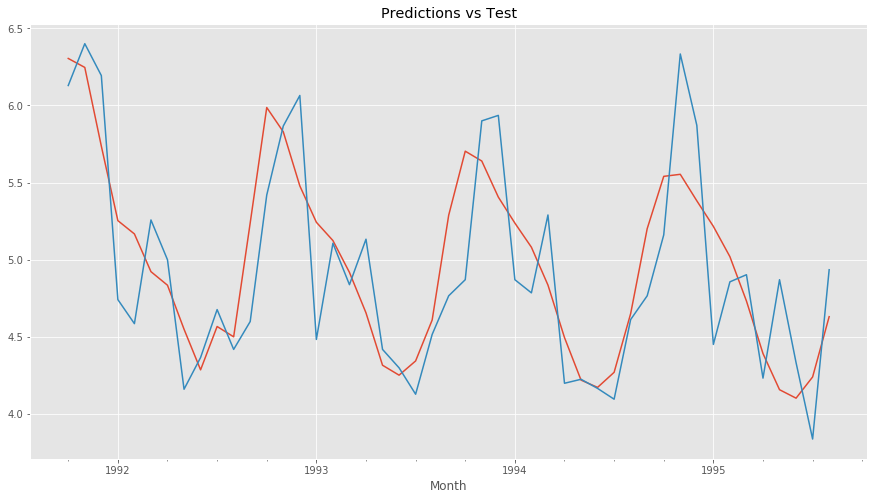

In [332]:
pd.Series(f, index=time_test).plot()
pd.Series(y_test, index=time_test).plot()
plt.title('Predictions vs Test')

In [302]:
measure_error(actual=f, pred=y_test, label=None, show=True)

RMSE = 0.4035626822216564
label = None
RMSE_pcent = 0.08121332728149465


{'RMSE': 0.4035626822216564, 'RMSE_pcent': 0.08121332728149465, 'label': None}

In [320]:
def forecast_nn(model, X_test, horizon):
    
    forecast=[]
    test = X_test[0]
    for i in range(horizon):
        pred = model.predict(test.reshape(1,-1))[0][0]
        forecast.append(pred)
        test = np.append(test[1:],pred)
    
    return forecast

In [321]:
f_nn = forecast_nn(model=smodel2, X_test=X_test, horizon=len(y_test))

Text(0.5,1,'Predictions vs Test')

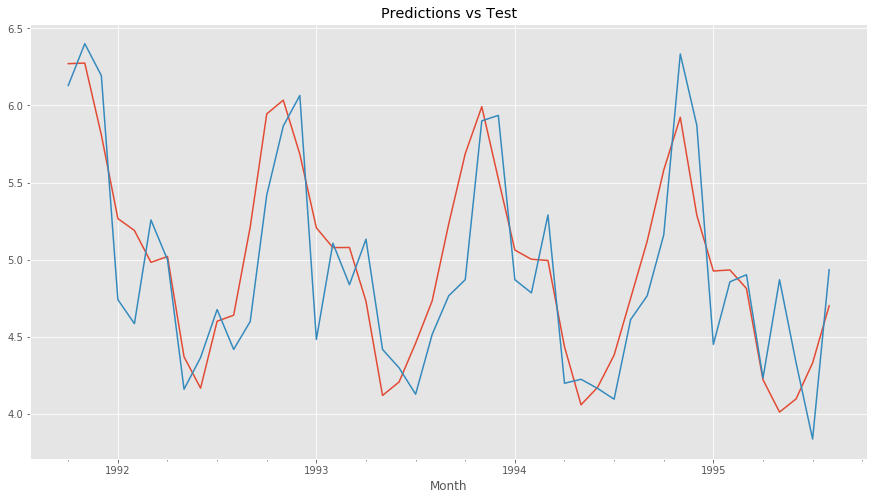

In [333]:
pd.Series(f_nn, index=time_test).plot()
pd.Series(y_test, index=time_test).plot()
plt.title('Predictions vs Test')

In [323]:
measure_error(actual=f_nn, pred=y_test, label=None, show=True)

RMSE = 0.36937679555023706
label = None
RMSE_pcent = 0.07407914146206321


{'RMSE': 0.36937679555023706, 'RMSE_pcent': 0.07407914146206321, 'label': None}

# SARIMA

In this section we will fit a SARIMA model.

In [255]:
X_train_series = beer['daily'][time_train[0]:time_train[-1]]
X_val_series = beer['daily'][time_val[0]:time_val[-1]]
X_test_series = beer['daily'][time_test[0]:time_test[-1]]

In [256]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
    
def measure_error(actual, pred, label=None, show=True):
    sq_error = mean_squared_error(actual, pred)
    mse = np.mean(sq_error)**.5
    avg = np.mean(actual)
    errors = {'RMSE': mse, 'RMSE_pcent': mse / avg, 'label':label}
    if show:
        for (k,v) in errors.items():
            print('%s = %s' % (k,v))
    return errors


def run_ad_fuller(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
        print('\nWe fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary')
    else:
        print('\nWe reject the Null Hypothesis (H0) -- the time series is stationary')
    p_value=result[1]
    return p_value

def make_stationary(X, max_diff=10, boxcox_transformation=True):
    
    import copy
    p_value_diff=1
    p_value_boxcox=1
    i=1
    s = copy.deepcopy(X)
    lbda=None
    
    if boxcox_transformation==True:
        s, lbda = stats.boxcox(X)
        s = pd.Series(s, index=X.index)
        print("Series after boxcox transformation")
        p_value_boxcox=run_ad_fuller(s)
    
    #if boxcox transformation makes the series stationary, we skip this
    if p_value_boxcox>0.05:
        while p_value_diff>0.05:
            s=s.diff(periods=1)
            print("Series after {} differencing".format(i))
            p_value_diff= run_ad_fuller(s.dropna())
            i+=1
            if i==max_diff:
                break   
    return s.dropna(), lbda

def box_cox(X):
    f = plt.figure()
    ax_1 = f.add_subplot(211)
    
    prob = stats.probplot(X, dist=stats.norm, plot=ax_1)
    ax_1.set_xlabel('')
    ax_1.set_title('Probability vs Normal')

    ax_2 = f.add_subplot(212)
    Y, lbda = stats.boxcox(X)
    Y=pd.Series(Y, index=X.index)
    prob = stats.probplot(Y, dist=stats.norm, plot=ax_2)
    ax_2.set_title('After Box-Cox transformation')
    plt.show()
    print('lambda : %f'% lbda)
    print('std(R)', np.std(X), np.mean(X), np.std(X)/ np.mean(X))
    print('std(Y)', np.std(Y), np.mean(Y),np.std(Y)/ np.mean(Y))
    return (Y,lbda)

def inv_box_cox(y,lbda):
    if lbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lbda * np.array(y) + 1) / lbda)

Making the series stationary with a Box-Cox transformation:

In [257]:
X_train_series_new, lbda = make_stationary(X_train_series, max_diff=10, boxcox_transformation=True)
lbda

Series after boxcox transformation
ADF Statistic: -1.828678
p-value: 0.366320
Critical Values:
	5%: -2.870
	1%: -3.449
	10%: -2.571

We fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary
Series after 1 differencing
ADF Statistic: -5.703964
p-value: 0.000001
Critical Values:
	5%: -2.870
	1%: -3.449
	10%: -2.571

We reject the Null Hypothesis (H0) -- the time series is stationary


0.7688607756627696

Running the SARIMA model. The order was selected doing a grid search (see the last section of the notebook):

In [258]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [259]:
#(4,1,1),(3,1,1)
sarima_model = SARIMAX(X_train_series_new, trend='n', order=(5,1,0), seasonal_order=(4,0,1,12))
f = sarima_model.fit()

Predict and check errors on validation set:

In [260]:
y_hat_sarima_val = f.forecast(steps=len(X_val_series))

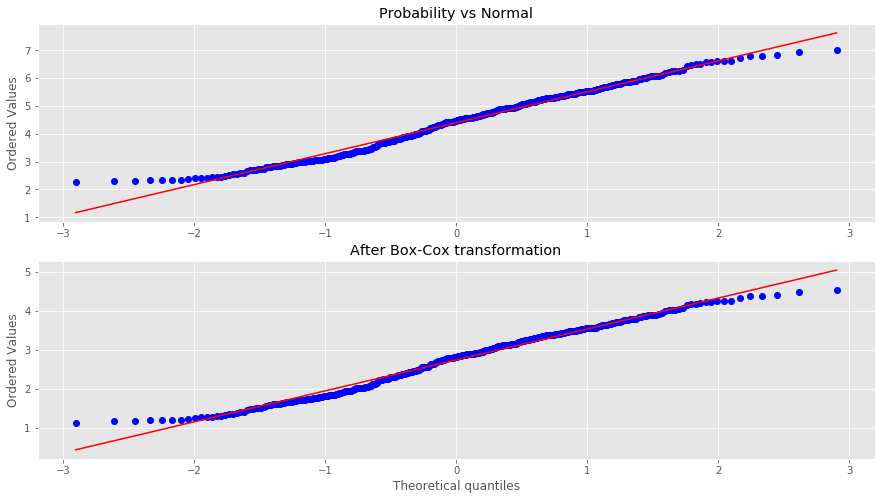

lambda : 0.768861
std(R) 1.1135730927612475 4.3960269880113705 0.2533135250984877
std(Y) 0.7956317076702457 2.7360222665883662 0.29079869611673315


0.7688607756627696

In [261]:
X_train_sarima_bc, lbda2 = box_cox(beer['daily'][time_train[0]:time_train[-1]])
lbda2

In [262]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval] 
    
history_sarima=[X_train_sarima_bc[time_train[-1]]] #first value
y_hat_sarima_val_undiff=[]

for pred in y_hat_sarima_val:
    pred_new = inverse_difference(history_sarima, pred, interval=1)
    y_hat_sarima_val_undiff.append(pred_new)
    history_sarima.append(pred_new)

In [263]:
y_hat_sarima_val_undiff_unbc = inv_box_cox(y_hat_sarima_val_undiff,lbda=0.7688607756627696)

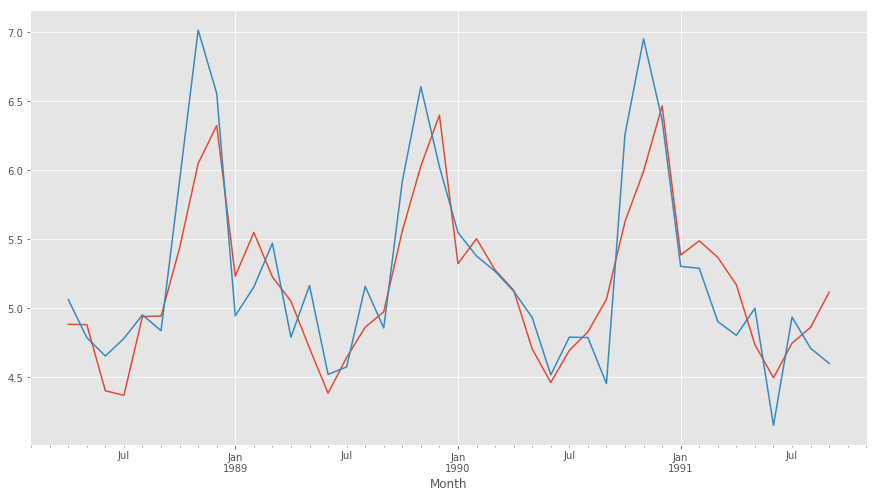

In [264]:
pd.Series(y_hat_sarima_val_undiff_unbc, index=time_val).plot()
pd.Series(y_val, index=time_val).plot()

In [265]:
measure_error(y_val, y_hat_sarima_val_undiff_unbc, label=None, show=True)

RMSE = 0.36400680930503465
label = None
RMSE_pcent = 0.06954617750444142


{'RMSE': 0.36400680930503465, 'RMSE_pcent': 0.06954617750444142, 'label': None}

Predictions on test set:

In [266]:
y_hat_sarima_test = f.forecast(steps=(len(X_val_series)+len(X_test_series)))
#y_hat_sarima_test = y_hat_sarima_test[len(X_val_series):len(X_test_series)]

In [267]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval] 
    
history_sarima=[X_train_sarima_bc[time_train[-1]]] #first value
y_hat_sarima_test_undiff=[]

for pred in y_hat_sarima_test:
    pred_new = inverse_difference(history_sarima, pred, interval=1)
    y_hat_sarima_test_undiff.append(pred_new)
    history_sarima.append(pred_new)

In [268]:
y_hat_sarima_test_undiff_unbc = inv_box_cox(y_hat_sarima_test_undiff,lbda=0.7688607756627696)

In [269]:
y_hat_sarima_test_undiff_unbc = y_hat_sarima_test_undiff_unbc[len(X_val_series):len(X_val_series)+len(X_test_series)]

Text(0.5,1,'Predictions vs Test')

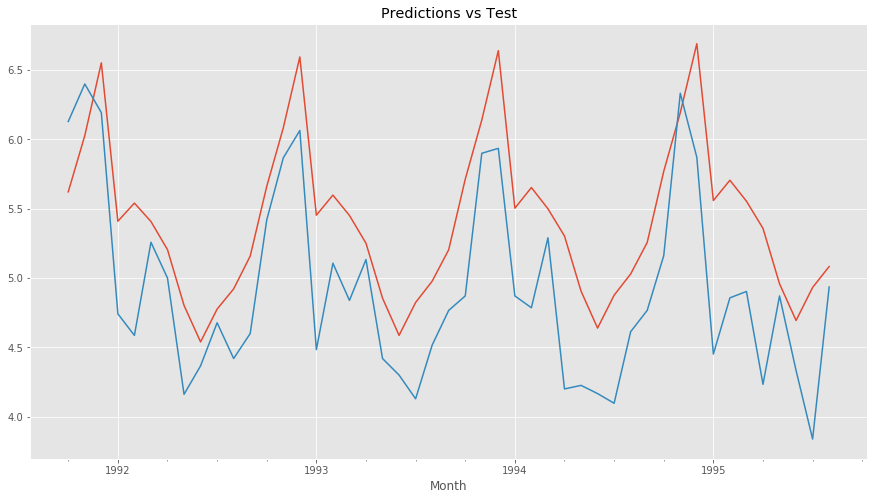

In [270]:
pd.Series(y_hat_sarima_test_undiff_unbc, index=time_test).plot()
pd.Series(y_test, index=time_test).plot()
plt.title('Predictions vs Test')

In [55]:
measure_error(y_test, y_hat_sarima_test_undiff_unbc, label=None, show=True)

RMSE_pcent = 0.12346994797377364
RMSE = 0.6070780130813009
label = None


{'RMSE': 0.6070780130813009, 'RMSE_pcent': 0.12346994797377364, 'label': None}

Function to make grid search:

In [31]:
def ljungbox_sarima(arima_fitted_model, lags, seasonal_interval): 

    from statsmodels.stats.diagnostic import acorr_ljungbox
    (lb, p_values) = acorr_ljungbox(arima_fitted_model.resid[seasonal_interval+1:], lags=lags, boxpierce=False)
    print('Ljung-Box Test')
    print('p_values:',p_values)
    result = False in list(map(lambda p: p >.05, p_values) )
    print('\n-------\nAny false Null hypotheses? %s\n-------\n' % result )
    issues = []
    for n,p in enumerate(p_values):
        if p < .05:
            issues += [(n+1, p)]
    print('LAGS WITH INFORMATION:',issues)
    ts_plot(arima_fitted_model.resid[seasonal_interval+1:],lags=lags)
    return issues


def grid_test(X_train, X_val, grid_size, seasonal_interval, ljungbox_lags, lbda, invert_boxcox=True):

    min_error=1000000000
    error=1000000000
    issues=[]
    best_params={'p':None, 'd':None, 'q': None, 'P': None, 'D': None, 'Q': None}
    
    ps=range(0,grid_size)
    ds=range(0,2)
    qs=range(0,2)
    Ps=range(0,grid_size)
    Ds=range(0,2)
    Qs=range(0,2)
    i=1
    j=len(ps)*len(ds)*len(qs)*len(Ps)*len(Ds)*len(Qs)
      
    for p in ps:
        for d in ds:
            for q in qs:
                for P in Ps:
                    for D in Ds:
                        for Q in Qs:   
                            print("Iteration {} of {}".format(i,j))
                            try:
                                model = SARIMAX(X_train, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,seasonal_interval))
                                f = model.fit()
                                y_hat = f.forecast(steps=len(X_val))
                                
                                history_sarima=[X_train_sarima_bc[time_train[-1]]] #first value
                                y_hat_undiff=[]

                                for pred in y_hat:
                                    pred_new = inverse_difference(history_sarima, pred, interval=1)
                                    y_hat_undiff.append(pred_new)
                                    history_sarima.append(pred_new)
                                
                                y_hat_undiff_unbc = inv_box_cox(y_hat_undiff,lbda=lbda)
                                
                                errors = measure_error(X_val, y_hat_undiff_unbc, label=None, show=False)
                                error = errors['RMSE']
                                #issues=ljungbox_sarima(f, ljungbox_lags, seasonal_interval)
                                print(error)
                            except:
                                pass
                            
                            if (error < min_error):# & (len(issues) == 0):
                                min_error=error
                                best_params['p']=p
                                best_params['d']=d
                                best_params['q']=q
                                best_params['P']=P
                                best_params['D']=D
                                best_params['Q']=Q
                                
                            i +=1
    
    return best_params, min_error    

In [36]:
best_params, min_error = grid_test(X_train=X_train_series_new, X_val=X_val_series, grid_size=6, seasonal_interval=12, ljungbox_lags=20, lbda=0.7688607756627696, invert_boxcox=True)

Iteration 1 of 576
Iteration 2 of 576
0.7535524933831677
Iteration 3 of 576
Iteration 4 of 576
0.4061038978811905
Iteration 5 of 576
0.7334450101523254
Iteration 6 of 576
0.409974149223847
Iteration 7 of 576
0.6268688018514786
Iteration 8 of 576
0.43640724366844386
Iteration 9 of 576
0.6140656500779188
Iteration 10 of 576
0.4399709962264691
Iteration 11 of 576
0.5413000233521368
Iteration 12 of 576
0.4773380249815385
Iteration 13 of 576
0.5864604518233164
Iteration 14 of 576
0.48133580723919595
Iteration 15 of 576
0.44432504707291426
Iteration 16 of 576
0.6103475790497466
Iteration 17 of 576
0.49032390504742435
Iteration 18 of 576
0.6073291614789296
Iteration 19 of 576
0.7544900786026705
Iteration 20 of 576
0.795378489406343
Iteration 21 of 576
0.7245084216643877
Iteration 22 of 576
0.7760663581830425
Iteration 23 of 576
0.6957762369404875
Iteration 24 of 576
0.7097965721622883
Iteration 25 of 576
0.6933288361140024
Iteration 26 of 576
0.6503540196134495
Iteration 27 of 576
0.579877748

C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.48181997683268774
Iteration 83 of 576
Iteration 84 of 576
Iteration 85 of 576
0.572294685917358
Iteration 86 of 576
0.578121963905333
Iteration 87 of 576
Iteration 88 of 576
Iteration 89 of 576
0.48386758680930897
Iteration 90 of 576
0.7667272427820422
Iteration 91 of 576
Iteration 92 of 576
Iteration 93 of 576
0.7216658313789465
Iteration 94 of 576
0.7855943867968408
Iteration 95 of 576
Iteration 96 of 576
Iteration 97 of 576
0.6931115629443384
Iteration 98 of 576
0.6693789018785469
Iteration 99 of 576
0.6155288297402786
Iteration 100 of 576
0.3834291157207966
Iteration 101 of 576
0.5793025443800711
Iteration 102 of 576
0.38565300334910413
Iteration 103 of 576
0.567420968651668
Iteration 104 of 576
0.39089124875236175
Iteration 105 of 576
0.5498627077577597
Iteration 106 of 576
0.3927433826387287
Iteration 107 of 576
0.5174262646260993
Iteration 108 of 576
0.3892658150842011
Iteration 109 of 576
0.5155820300854514
Iteration 110 of 576
0.39220460844709976
Iteration 111 of 576
0.46504

C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.5642627132826284
Iteration 178 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.39861747821046495
Iteration 179 of 576
0.5216886009114234
Iteration 180 of 576
0.4377183295568304
Iteration 181 of 576
0.5280039029854913
Iteration 182 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.42709496186538554
Iteration 183 of 576
0.4679127106069178
Iteration 184 of 576
0.5174629222535164
Iteration 185 of 576
0.47606862310244275
Iteration 186 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.5379587584326317
Iteration 187 of 576
0.49951798213640614
Iteration 188 of 576
0.6543911995216164
Iteration 189 of 576
0.4807844103172381
Iteration 190 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.6416482216869993
Iteration 191 of 576
0.5551449602228974
Iteration 192 of 576
0.6034094227516504
Iteration 193 of 576
0.6932458509705475
Iteration 194 of 576
0.6773953716390038
Iteration 195 of 576
0.6160176837760315
Iteration 196 of 576
0.40148729455608245
Iteration 197 of 576
0.550855466630373
Iteration 198 of 576
0.4020999865199159
Iteration 199 of 576
0.5285161709081733
Iteration 200 of 576
0.4010577277897502
Iteration 201 of 576
0.5114900678309124
Iteration 202 of 576
0.40187305507170507
Iteration 203 of 576
0.4796187724783433
Iteration 204 of 576
0.40474013214925963
Iteration 205 of 576
0.47361214765454734
Iteration 206 of 576
0.40537844502582343
Iteration 207 of 576
0.43954073739173993
Iteration 208 of 576
0.4160709399566104
Iteration 209 of 576
0.43870537616697947
Iteration 210 of 576
0.41718617004270164
Iteration 211 of 576
0.41410974897725167
Iteration 212 of 576
0.4736453957727572
Iteration 213 of 576
0.41304871473127114
Iteration 214 of 576
0.4750457187293767
Iteration 21

C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Iteration 248 of 576
Iteration 249 of 576
Iteration 250 of 576
Iteration 251 of 576
0.8852605235293127
Iteration 252 of 576
Iteration 253 of 576
Iteration 254 of 576
Iteration 255 of 576
0.9949673644678609
Iteration 256 of 576
Iteration 257 of 576
2.807240212405334
Iteration 258 of 576
Iteration 259 of 576
Iteration 260 of 576
Iteration 261 of 576
Iteration 262 of 576
Iteration 263 of 576
Iteration 264 of 576
Iteration 265 of 576
0.7151618479826656
Iteration 266 of 576
0.6654350466280698
Iteration 267 of 576
0.6276642278968677
Iteration 268 of 576
Iteration 269 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.5401133471878982
Iteration 270 of 576
0.4180137686608621
Iteration 271 of 576
0.5285812492471025
Iteration 272 of 576
0.4446222394948476
Iteration 273 of 576
0.51169526912728
Iteration 274 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.41867902817308894
Iteration 275 of 576
0.48017522831086124
Iteration 276 of 576
0.45291962951570175
Iteration 277 of 576
0.4732862555905473
Iteration 278 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4258889381746237
Iteration 279 of 576
0.43960335979850024
Iteration 280 of 576
0.4669269773774449
Iteration 281 of 576
0.43960854965127594
Iteration 282 of 576
0.4421414790956647
Iteration 283 of 576
0.41896965416828313
Iteration 284 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.5243528187283325
Iteration 285 of 576
0.41160212870861795
Iteration 286 of 576
0.5212981580011853
Iteration 287 of 576
0.434737228434137
Iteration 288 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.5323660927548851
Iteration 289 of 576
0.7144496231438282
Iteration 290 of 576
0.7067140470663857
Iteration 291 of 576
0.5895167687186232
Iteration 292 of 576
0.39012438341903405
Iteration 293 of 576
0.5331968286159421
Iteration 294 of 576
0.39142752133521896
Iteration 295 of 576
0.5409406408831661
Iteration 296 of 576
0.38946329775898353
Iteration 297 of 576
0.5187529929934738
Iteration 298 of 576
0.3909400676247068
Iteration 299 of 576
0.4891304571370618
Iteration 300 of 576
0.38894539852973886
Iteration 301 of 576
0.47936221856805894
Iteration 302 of 576
0.3904641014580867
Iteration 303 of 576
0.4460320241356032
Iteration 304 of 576
0.3944973391436845
Iteration 305 of 576
0.4433914206937122
Iteration 306 of 576
0.3961790360436423
Iteration 307 of 576
0.3963031236599377
Iteration 308 of 576
0.45418000477569037
Iteration 309 of 576
0.3947029646935288
Iteration 310 of 576
0.45319846554425963
Iteration 311 of 576
0.39729887519449114
Iteration 312 of 576
0.45608727459883325
Iteration 31

C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4954605357548209
Iteration 326 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.398612213949103
Iteration 327 of 576
0.4673108145969302
Iteration 328 of 576
0.409714494307251
Iteration 329 of 576
0.4644619080344874
Iteration 330 of 576
0.4121188507764401
Iteration 331 of 576
0.46162876976929973
Iteration 332 of 576
0.4627774573517395
Iteration 333 of 576
0.460083461144654
Iteration 334 of 576
0.4628154184417367
Iteration 335 of 576
0.46569754545179276
Iteration 336 of 576
0.4730494325659803
Iteration 337 of 576
Iteration 338 of 576
Iteration 339 of 576
Iteration 340 of 576
Iteration 341 of 576
Iteration 342 of 576
2.744725380894664
Iteration 343 of 576
2.73918303664992
Iteration 344 of 576
2.7310300778849292
Iteration 345 of 576
Iteration 346 of 576
2.879393938159736
Iteration 347 of 576
0.955443545013276
Iteration 348 of 576
2.8120330973400143
Iteration 349 of 576
2.7192437741554554
Iteration 350 of 576
2.9774920013082604
Iteration 351 of 576
0.7282103276594306
Iteration 352 of 576
3.0686622849140353
Iteration 353 of 576
2.116271489530104
Iteration 354 of 576
3

C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.417157800711801
Iteration 371 of 576
0.48934700126653724
Iteration 372 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.42963382780892295
Iteration 373 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4796613154309175
Iteration 374 of 576
Iteration 375 of 576
0.4457356152821854
Iteration 376 of 576
0.4395803860938066
Iteration 377 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.444920343325382
Iteration 378 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.42855652064445016
Iteration 379 of 576
0.3998873630500227
Iteration 380 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.49442707690473203
Iteration 381 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.3949481400424781
Iteration 382 of 576
0.5128203074046218
Iteration 383 of 576
0.41128654304089013
Iteration 384 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.485740385595828
Iteration 385 of 576
0.6966056204767321
Iteration 386 of 576
0.658950696870235
Iteration 387 of 576
0.5622854703647324
Iteration 388 of 576
0.3849882170224887
Iteration 389 of 576
0.5265322231997498
Iteration 390 of 576
0.3853277063444595
Iteration 391 of 576
0.5345821188254464
Iteration 392 of 576
0.38294149230031715
Iteration 393 of 576
0.5204440653461764
Iteration 394 of 576
0.3834688825380501
Iteration 395 of 576
0.4801237591978764
Iteration 396 of 576
0.3787420423904406
Iteration 397 of 576
0.47220997769864126
Iteration 398 of 576
0.3792829029708494
Iteration 399 of 576
0.43908005001190314
Iteration 400 of 576
0.37753774372895754
Iteration 401 of 576
0.43796249192314135
Iteration 402 of 576
0.3779375601541325
Iteration 403 of 576
0.39185616297340725
Iteration 404 of 576
0.4224989543830908
Iteration 405 of 576
0.3881638904401707
Iteration 406 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.42084376325030876
Iteration 407 of 576
0.3798872070792003
Iteration 408 of 576
0.40675759422657276
Iteration 409 of 576
0.6881568567029324
Iteration 410 of 576
0.6546472059428169
Iteration 411 of 576
0.5266869361110802
Iteration 412 of 576
0.4083560320354372
Iteration 413 of 576
0.5106145123347017
Iteration 414 of 576
0.40862001131091585
Iteration 415 of 576
0.5262606598094749
Iteration 416 of 576
0.3981879124316794
Iteration 417 of 576
0.510255839863504
Iteration 418 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.399459292757735
Iteration 419 of 576
0.48528921907293004
Iteration 420 of 576
0.40125367205134105
Iteration 421 of 576
0.47632102828784
Iteration 422 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4024473241624749
Iteration 423 of 576
0.45371483334927865
Iteration 424 of 576
0.4085711854849232
Iteration 425 of 576
0.45084320254376653
Iteration 426 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4108957704175681
Iteration 427 of 576
0.45600173551304307
Iteration 428 of 576
0.45064904144284695
Iteration 429 of 576
0.4539109604157153
Iteration 430 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4524776322233397
Iteration 431 of 576
0.45825969094021984
Iteration 432 of 576
0.4633483128366834
Iteration 433 of 576
Iteration 434 of 576
Iteration 435 of 576
2.5975423444809436
Iteration 436 of 576
Iteration 437 of 576
Iteration 438 of 576
1.0384781816869384
Iteration 439 of 576
0.677618746739053
Iteration 440 of 576
1.1419224633476401
Iteration 441 of 576
1.5863811546677813
Iteration 442 of 576
1.2877040087797618
Iteration 443 of 576
1.0286954848389094
Iteration 444 of 576
1.3271817797378171
Iteration 445 of 576
0.8489855614398227
Iteration 446 of 576
1.4902748663494854
Iteration 447 of 576
1.180010689468809
Iteration 448 of 576
1.5434992424000442
Iteration 449 of 576
0.4586019910223474
Iteration 450 of 576
1.7302570805679034
Iteration 451 of 576
0.3911972578499693
Iteration 452 of 576
1.7409581356322987
Iteration 453 of 576
0.9058853227904092
Iteration 454 of 576
1.969105070879047
Iteration 455 of 576
0.49768264524652894
Iteration 456 of 576
1.731462799453894
Iteration 457 of 57

C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.5346962101850833
Iteration 464 of 576
0.3974019302063617
Iteration 465 of 576
0.5259154821401145
Iteration 466 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4045406361844984
Iteration 467 of 576
0.4801877015368046
Iteration 468 of 576
0.40776858391851445
Iteration 469 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4735130324199097
Iteration 470 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.3950694606434234
Iteration 471 of 576
0.43914724447943426
Iteration 472 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4129244782149808
Iteration 473 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4394804120976065
Iteration 474 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.40388293532674047
Iteration 475 of 576
0.3954108257863854
Iteration 476 of 576
0.4584269122345059
Iteration 477 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.3883427531344731
Iteration 478 of 576
0.4487040144930909
Iteration 479 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.39162761032781546
Iteration 480 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4564683500219236
Iteration 481 of 576
0.6963100102886626
Iteration 482 of 576
0.658224453710431
Iteration 483 of 576
0.4791241832793552
Iteration 484 of 576
0.38837570292640916
Iteration 485 of 576
0.48027418774879505
Iteration 486 of 576
0.3882550865622358
Iteration 487 of 576
0.48392854164068666
Iteration 488 of 576
0.38373330502370656
Iteration 489 of 576
0.4787154550756039
Iteration 490 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.3842328445375709
Iteration 491 of 576
0.45399373591722536
Iteration 492 of 576
0.3857384470304705
Iteration 493 of 576
0.44747206849109045
Iteration 494 of 576
0.38508881340638734
Iteration 495 of 576
0.42516154325274813
Iteration 496 of 576
0.38667763010404177
Iteration 497 of 576
0.4226967837749101
Iteration 498 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.3863442212266613
Iteration 499 of 576
0.41311254216532267
Iteration 500 of 576
0.4247164106754298
Iteration 501 of 576
0.40686182935977144
Iteration 502 of 576
0.42366327687751076
Iteration 503 of 576
0.4068429520706926
Iteration 504 of 576
0.4149838220276317
Iteration 505 of 576
0.6672613413391127
Iteration 506 of 576
0.6492276833944455
Iteration 507 of 576
0.5478110333492859
Iteration 508 of 576
0.40955922956985913
Iteration 509 of 576
0.5096850700954542
Iteration 510 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4092896539144135
Iteration 511 of 576
0.5262265992523677
Iteration 512 of 576
0.3994493245095658
Iteration 513 of 576
0.511275109472619
Iteration 514 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.3998307458398482
Iteration 515 of 576
0.48526666318470557
Iteration 516 of 576
0.40281341300848084
Iteration 517 of 576
0.47631895621007797
Iteration 518 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4020794550313415
Iteration 519 of 576
0.4540198659420579
Iteration 520 of 576
0.40963311034584077
Iteration 521 of 576
0.4508564881811428
Iteration 522 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4112489970885653
Iteration 523 of 576
0.45614912678349917
Iteration 524 of 576
0.4510760763145732
Iteration 525 of 576
0.45384015464558314
Iteration 526 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.45256011532594465
Iteration 527 of 576
0.4592811154108807
Iteration 528 of 576
0.4645333271620919
Iteration 529 of 576
Iteration 530 of 576
Iteration 531 of 576
0.4977924035614824
Iteration 532 of 576
Iteration 533 of 576
0.6831765782027643
Iteration 534 of 576
0.42627943081200914
Iteration 535 of 576
1.7284075833403807
Iteration 536 of 576
0.4241721045045455
Iteration 537 of 576
1.2366383544402935
Iteration 538 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4059310126303756
Iteration 539 of 576
1.4374667494526674
Iteration 540 of 576
0.3859049863310076
Iteration 541 of 576
1.1619828402633117
Iteration 542 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.37523648082756295
Iteration 543 of 576
1.7171343403233648
Iteration 544 of 576
0.3683588347946515
Iteration 545 of 576
1.4547860024768393
Iteration 546 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.364121699991962
Iteration 547 of 576
1.1911196414627376
Iteration 548 of 576
0.42980273394507
Iteration 549 of 576
1.0048449607066547
Iteration 550 of 576
0.46222443082110776
Iteration 551 of 576
0.9850252705001649
Iteration 552 of 576
0.37903878144744074
Iteration 553 of 576
0.7134358804166189
Iteration 554 of 576
0.6642905442378827
Iteration 555 of 576
Iteration 556 of 576
Iteration 557 of 576
0.48967134446029864
Iteration 558 of 576
0.4279606472925421
Iteration 559 of 576
Iteration 560 of 576
Iteration 561 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4799770481261404
Iteration 562 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4237904823951735
Iteration 563 of 576
Iteration 564 of 576
Iteration 565 of 576
0.4470328845169156
Iteration 566 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4182005090147288
Iteration 567 of 576
Iteration 568 of 576
Iteration 569 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.42272804803651104
Iteration 570 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4147273251289167
Iteration 571 of 576
Iteration 572 of 576
Iteration 573 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.4110627567470654
Iteration 574 of 576


C:\Users\prodi\Anaconda3\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.46639357804599646
Iteration 575 of 576
Iteration 576 of 576


In [37]:
best_params, min_error

({'D': 0, 'P': 4, 'Q': 1, 'd': 1, 'p': 5, 'q': 0}, 0.364121699991962)